### Predict Sahel rainfall with convolutional neural networks (CNNs)

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

The task is to **reconstruct current** (lead 0) Sahel precipitation index (PREC_SAHEL) from the remaining indices. Additionally, we will try to **predict future** Sahel rainfall (lead times 1 / 3 / 6 months) from available information ($t\leq 0$) of all input features, including PREC_SAHEL. 

Here, we train plain **CNN/fc** models.

- Prepare inputs and targets.
- Set up model.
- Evaluate model performance.

**Note:** We started with predicting future Sahel rainfall from its own history alone, hence with **univariate** inputs. Now, we add further input features to have **multivariate** inputs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import additional functions:
import sys
sys.path.append('../src')
from preprocessing import bar_color, split_sequence
from models import set_CNN_fc

### Prepare inputs and targets

- Load collection of climate indices directly from GitHub release.
- Create targets with desired lead times.
- Extract remaining indices as inputs.

In [2]:
# Set url:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Load data:
climind = pd.read_csv(data_url)

# Format data:
climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]

In [3]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Extract target series (PREC_SAHEL) and keep ALL indices (including PREC_SAHEL) as inputs:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'PREC_SAHEL']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'PREC_SAHEL']
input_FOCI = climind_FOCI.loc[:]
input_CESM = climind_CESM.loc[:]

# Normalize target series to have zero mean and unit variance:
target_FOCI = (target_FOCI - np.mean(target_FOCI)) / np.std(target_FOCI)
target_CESM = (target_CESM - np.mean(target_CESM)) / np.std(target_CESM)

# Create targets with lead time 1, 3, 6 months:
target_FOCI_lead1 = target_FOCI[1:-5].values
target_FOCI_lead3 = target_FOCI[3:-3].values
target_FOCI_lead6 = target_FOCI[6:].values
target_CESM_lead1 = target_CESM[1:-5].values
target_CESM_lead3 = target_CESM[3:-3].values
target_CESM_lead6 = target_CESM[6:].values

# Erase last 6 rows from inputs and target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]

# Add targets with individual lead times as new columns:
target_FOCI['PREC_SAHEL_lead1'] = target_FOCI_lead1
target_FOCI['PREC_SAHEL_lead3'] = target_FOCI_lead3
target_FOCI['PREC_SAHEL_lead6'] = target_FOCI_lead6
target_CESM['PREC_SAHEL_lead1'] = target_CESM_lead1
target_CESM['PREC_SAHEL_lead3'] = target_CESM_lead3
target_CESM['PREC_SAHEL_lead6'] = target_CESM_lead6

# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_FOCI.shape)
print("CESM inputs shape (time steps, features): ", input_CESM.shape)
print("\nFOCI target shape (time steps, features): ", target_FOCI.shape)
print("CESM target shape (time steps, features): ", target_CESM.shape)

FOCI inputs shape (time steps, features):  (11994, 29)
CESM inputs shape (time steps, features):  (11982, 29)

FOCI target shape (time steps, features):  (11994, 4)
CESM target shape (time steps, features):  (11982, 4)


### Check correlation

Next we check, how input features correlate to targets with different lead times.

<AxesSubplot:title={'center':'Pairwise correlation of input features and target series with different lead times (FOCI)'}, xlabel='index', ylabel='index'>

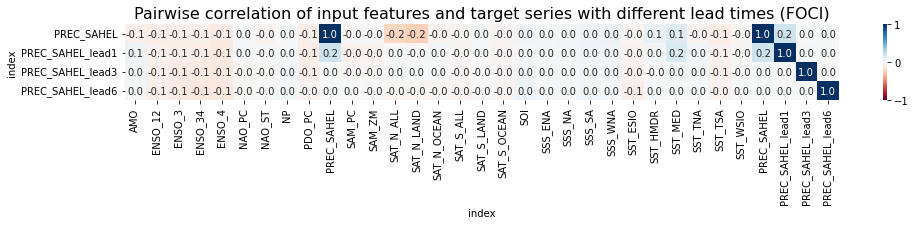

In [4]:
# Plot correlation of inputs and target series as heatmap:
fig, ax = plt.subplots(figsize=(16,1.4))
plt.title('Pairwise correlation of input features and target series with different lead times (FOCI)', fontsize=16)
sns.heatmap(
    pd.concat([input_FOCI, target_FOCI[['PREC_SAHEL', 'PREC_SAHEL_lead1', 'PREC_SAHEL_lead3', 'PREC_SAHEL_lead6']]], axis=1).corr()[-4:], 
    cmap="RdBu",
    xticklabels=True, 
    yticklabels=True,
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".1f",
)

### Discussion on correlation check

Find inputs and targets to be **mostly un-correlated**. If at all, we see some minor negative correlation between SAT anomaly indices (SAT_N_ALL and SAT_N_LAND) and Sahel Precipitation index (PREC_SAHEL). Correlation coefficient reads -0.2.

We also find a low level of **auto correlation**: Correlation of original PREC_SAHEL and targets with lead time 1 / 3 / 6 months reads 0.2 / 0.0 / 0.0, respectively.

### Multivariate CNN/fc model: Continue data pre-processing

We now continue to prepare inputs and targets and define model parameters:

- Specify and select input features to include.
- Set model parameters for CNN/fc model.
- Split inputs into sequences of specified input length.
- Split inputs and targets into train and test sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [4]:
## Set parameters for inputs and target:

# # Select input features:
# input_features = ['PREC_SAHEL']


# ALL input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]


# Specify relative amount of train data:
train_val_split = 0.9

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_01'

In [5]:
# Select specified input features:
input_selected_FOCI = input_FOCI[input_features]
input_selected_CESM = input_CESM[input_features]

In [6]:
## Set parameters:

# Data pre-processing:
input_length = 24

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_act = 'sigmoid'
output_act = 'linear'
n_epochs = 100
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

In [7]:
# Split input values into sequences of specified input length:
input_split_FOCI = split_sequence(input_selected_FOCI, input_length)
input_split_CESM = split_sequence(input_selected_CESM, input_length)

# Adjust targets: Cut first (input_length - 1) entries
target_cut_FOCI = target_FOCI[input_length-1:]
target_cut_CESM = target_CESM[input_length-1:]

In [8]:
## Split inputs and targets into train and test sets:

# Get number of train samples:
n_train = int(train_val_split * len(input_split_FOCI))

# Split inputs and targets:
train_input_FOCI = input_split_FOCI[:n_train]
train_input_CESM = input_split_CESM[:n_train]
test_input_FOCI = input_split_FOCI[n_train:]
test_input_CESM = input_split_CESM[n_train:]

train_target_FOCI = target_cut_FOCI[:n_train]
train_target_CESM = target_cut_CESM[:n_train]
test_target_FOCI = target_cut_FOCI[n_train:]
test_target_CESM = target_cut_CESM[n_train:]

# Check dimensions:
print("FOCI: train_input shape (samples, features): ", train_input_FOCI.shape)
print("FOCI_test_input shape (samples, features): ", test_input_FOCI.shape)
print("CESM: train_input shape (samples, features): ", train_input_CESM.shape)
print("CESM_test_input shape (samples, features): ", test_input_CESM.shape)
print("\nFOCI: train_target shape (samples, features): ", train_target_FOCI.shape)
print("FOCI: test_target shape (samples, features): ", test_target_FOCI.shape)
print("CESM train_target shape (samples, features): ", train_target_CESM.shape)
print("CESM: test_target shape (samples, features): ", test_target_CESM.shape)

FOCI: train_input shape (samples, features):  (10773, 24, 29)
FOCI_test_input shape (samples, features):  (1198, 24, 29)
CESM: train_input shape (samples, features):  (10773, 24, 29)
CESM_test_input shape (samples, features):  (1186, 24, 29)

FOCI: train_target shape (samples, features):  (10773, 4)
FOCI: test_target shape (samples, features):  (1198, 4)
CESM train_target shape (samples, features):  (10773, 4)
CESM: test_target shape (samples, features):  (1186, 4)


In [9]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
train_mean_FOCI = np.mean(train_input_FOCI, axis=0)
train_std_FOCI = np.std(train_input_FOCI, axis=0)
train_min_FOCI = np.min(train_input_FOCI, axis=0)
train_max_FOCI = np.max(train_input_FOCI, axis=0)
train_mean_CESM = np.mean(train_input_CESM, axis=0)
train_std_CESM = np.std(train_input_CESM, axis=0)
train_min_CESM = np.min(train_input_CESM, axis=0)
train_max_CESM = np.max(train_input_CESM, axis=0)

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    test_input_scaled_FOCI = (test_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    train_input_scaled_CESM = (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)
    test_input_scaled_CESM = (test_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = 2 * (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    test_input_scaled_FOCI = 2 * (test_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1 
    train_input_scaled_CESM = 2 * (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    test_input_scaled_CESM = 2 * (test_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (train_input_FOCI - train_mean_FOCI) / train_std_FOCI
    test_input_scaled_FOCI = (test_input_FOCI - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (train_input_CESM - train_mean_CESM) / train_std_CESM
    test_input_scaled_CESM = (test_input_CESM - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print("FOCI: train_input MIN: ", np.round(np.min(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MAX: ", np.round(np.max(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MEAN: ", np.round(np.mean(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input STD: ", np.round(np.std(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: test_input MIN: ", np.round(np.min(test_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: test_input MAX: ", np.round(np.max(test_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: test_input MEAN: ", np.round(np.mean(test_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: test_input STD: ", np.round(np.std(test_input_scaled_FOCI, axis=(0,1)), 2))
print("\n\nCESM: train_input MIN: ", np.round(np.min(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MAX: ", np.round(np.max(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MEAN: ", np.round(np.mean(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input STD: ", np.round(np.std(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: test_input MIN: ", np.round(np.min(test_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: test_input MAX: ", np.round(np.max(test_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: test_input MEAN: ", np.round(np.mean(test_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: test_input STD: ", np.round(np.std(test_input_scaled_CESM, axis=(0,1)), 2))

FOCI: train_input MIN:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
FOCI: train_input MAX:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
FOCI: train_input MEAN:  [0.45 0.45 0.48 0.4  0.49 0.44 0.47 0.5  0.49 0.3  0.57 0.6  0.5  0.54
 0.5  0.55 0.48 0.56 0.53 0.47 0.48 0.46 0.56 0.48 0.5  0.52 0.5  0.51
 0.51]
FOCI: train_input STD:  [0.13 0.12 0.12 0.13 0.16 0.12 0.12 0.12 0.14 0.06 0.14 0.14 0.11 0.12
 0.12 0.12 0.11 0.13 0.13 0.14 0.14 0.12 0.14 0.13 0.13 0.11 0.13 0.12
 0.12]
FOCI: test_input MIN:  [ 0.03  0.04  0.11 -0.04  0.02  0.11  0.12  0.04  0.14  0.06 -0.07  0.01
  0.14  0.1   0.04  0.3   0.1   0.28  0.11  0.07  0.01  0.03  0.1   0.02
  0.1   0.08 -0.01  0.12  0.09]
FOCI: test_input MAX:  [0.97 0.88 0.95 0.94 0.97 0.89 0.94 0.88 0.92 0.58 0.97 0.97 0.92 1.06
 0.88 0.9  0.95 0.9  0.87 0.93 0.91 0.92 0.93 0.95 1.   1.02 0.91 0.89
 0.97]
FOCI: test_input MEAN:  [0.49 0.47 0.5  0.42 0.52 0.

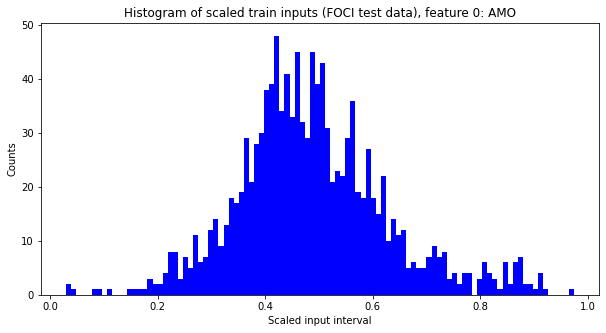

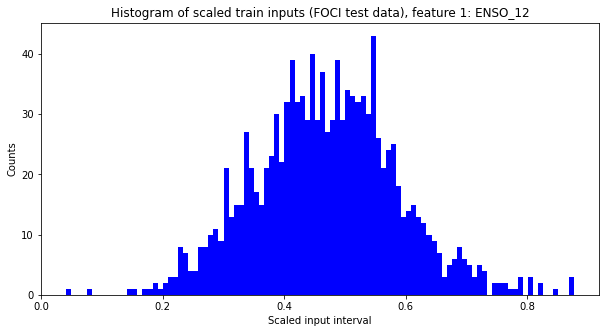

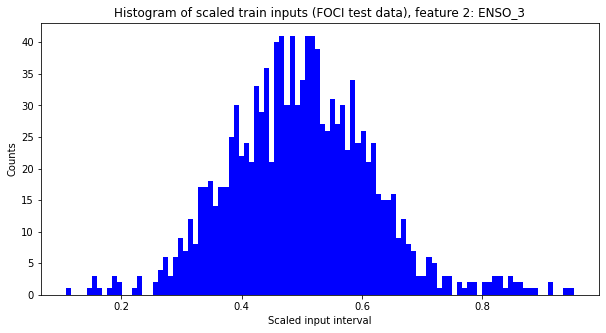

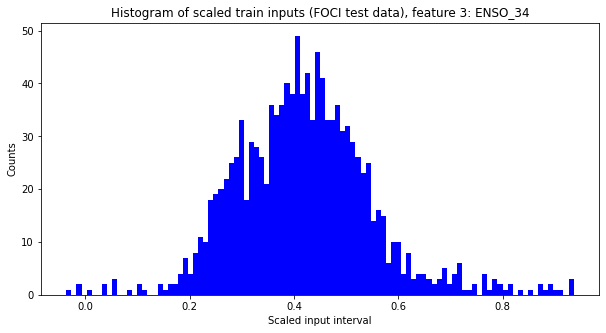

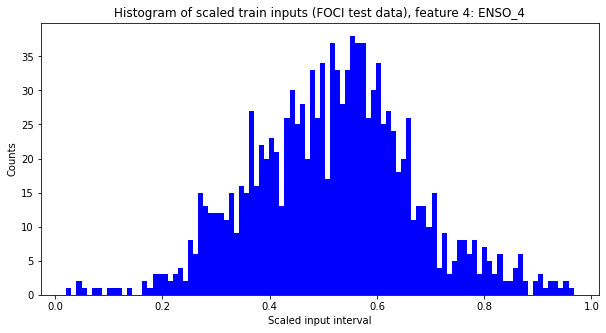

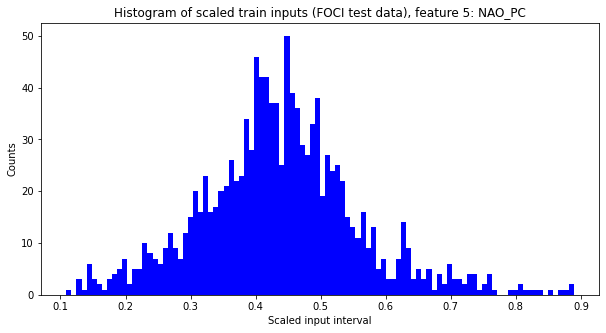

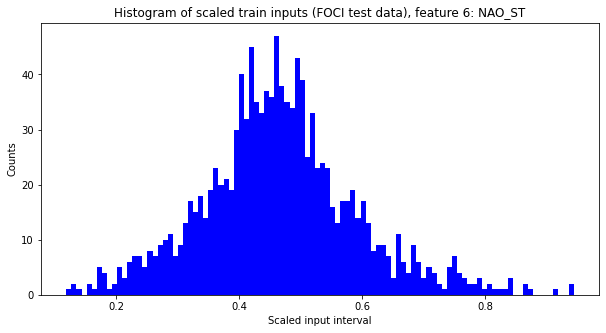

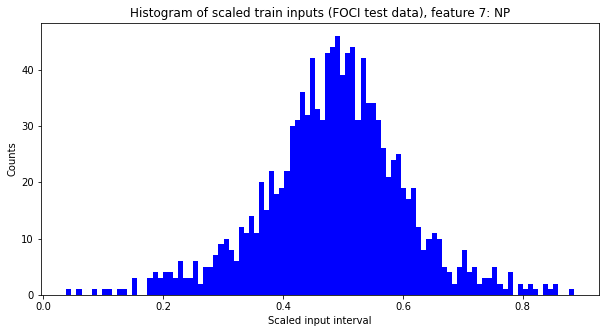

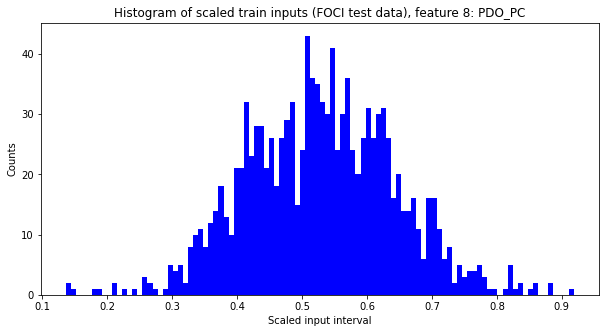

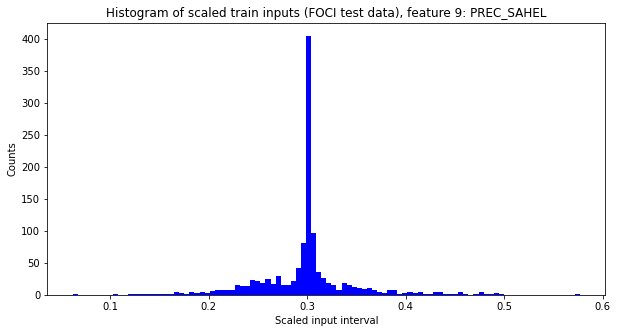

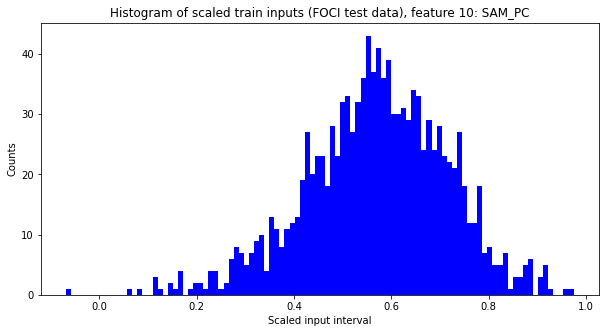

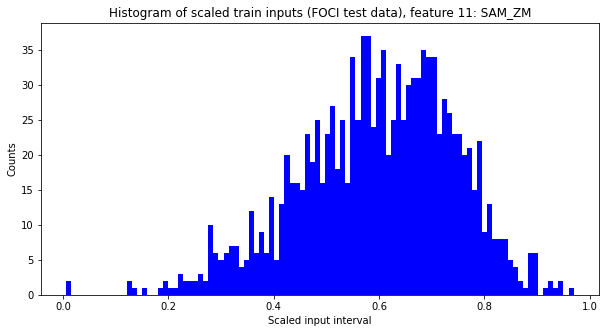

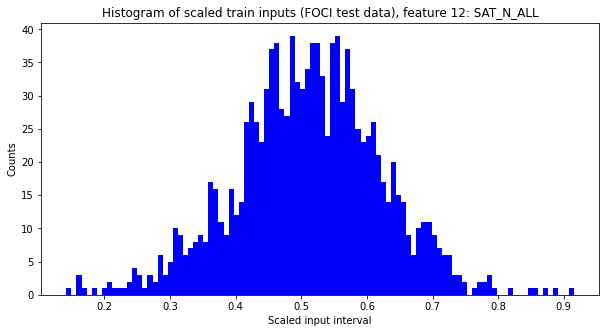

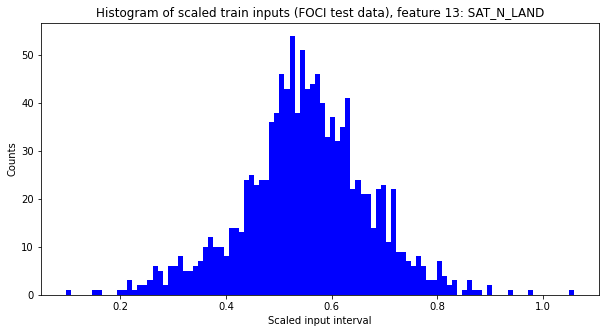

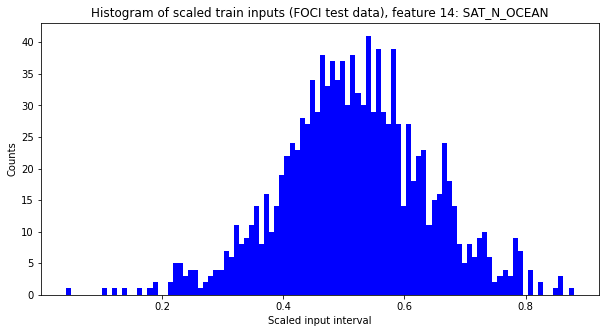

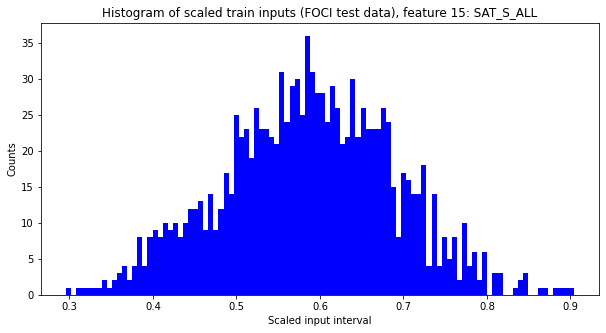

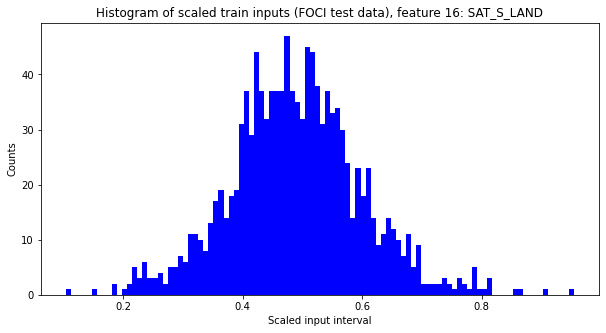

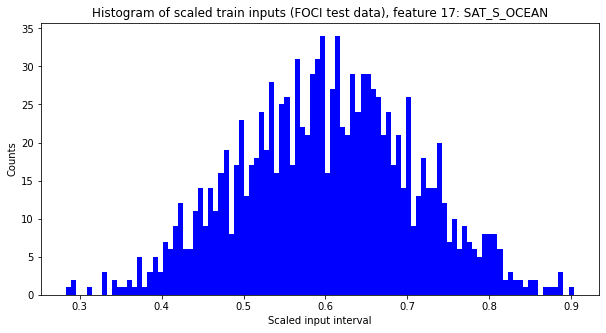

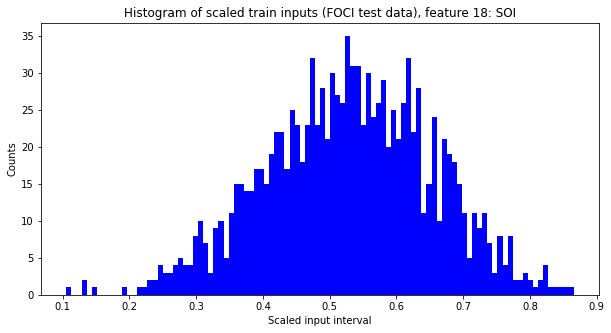

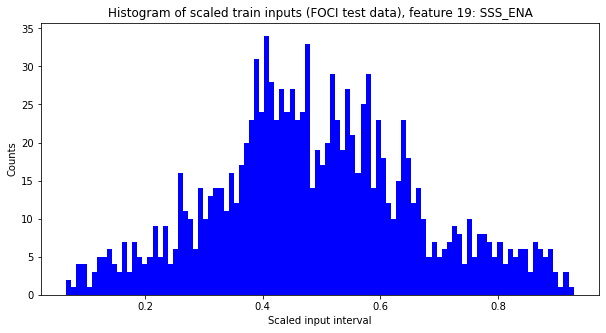

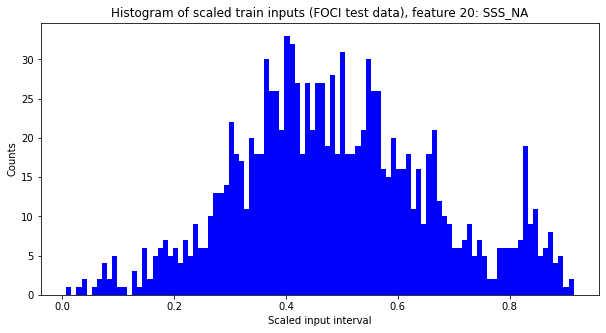

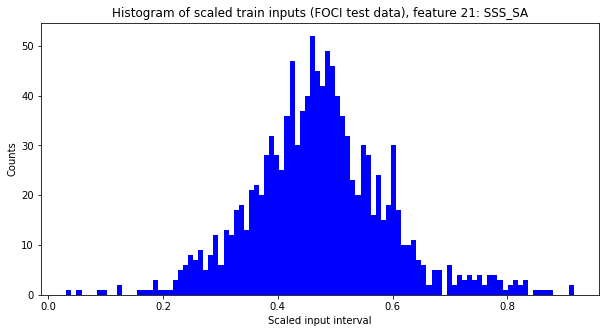

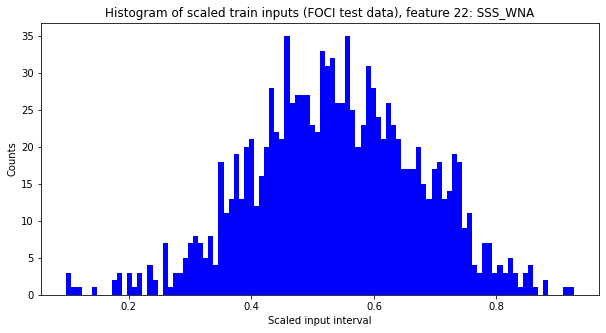

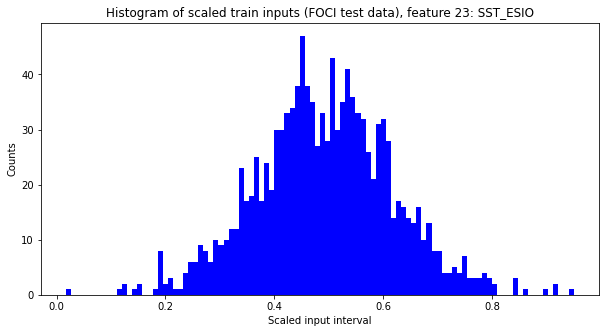

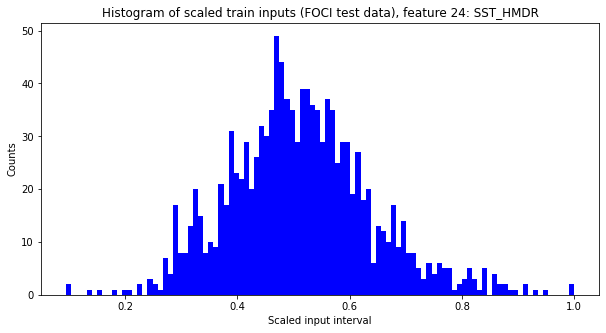

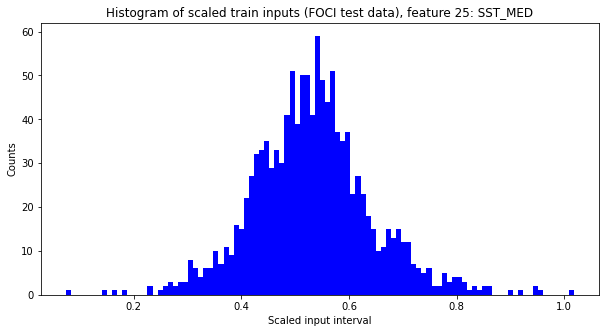

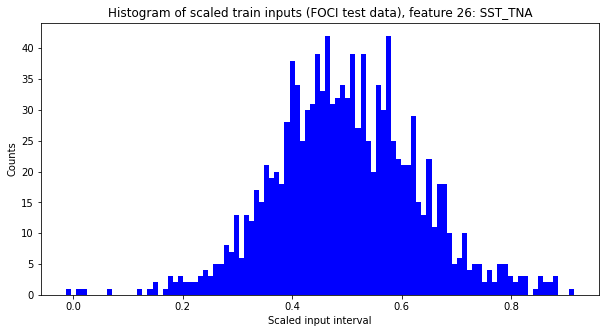

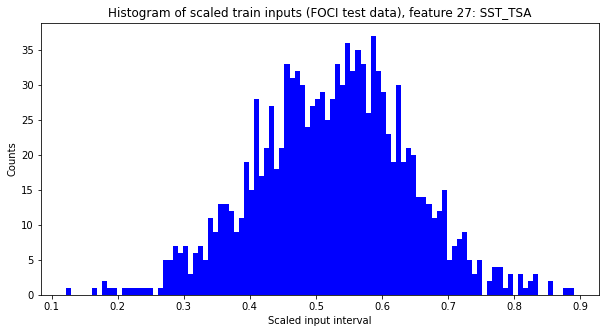

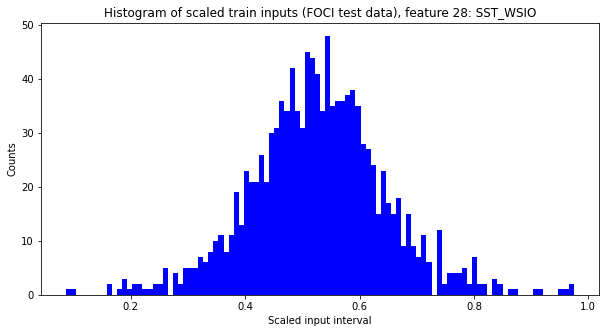

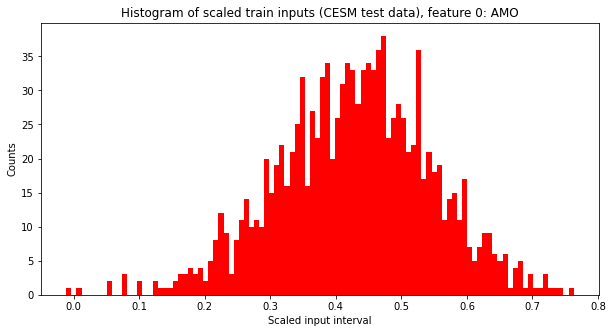

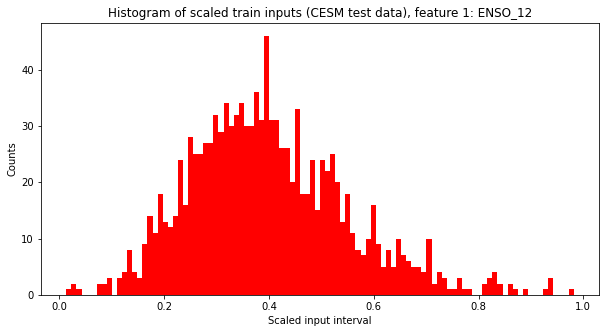

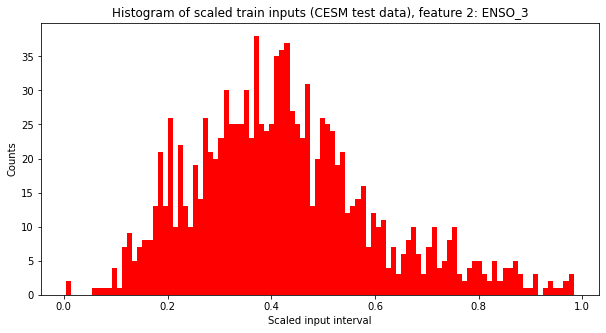

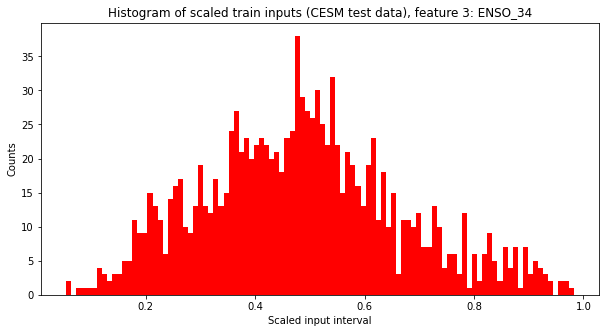

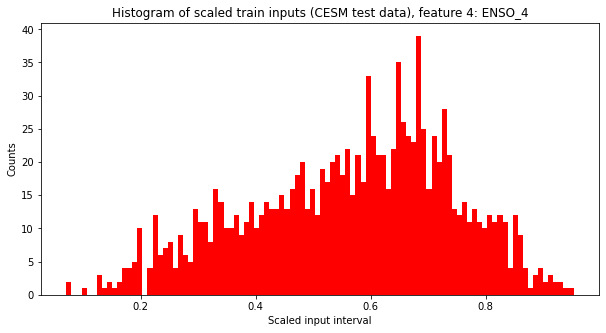

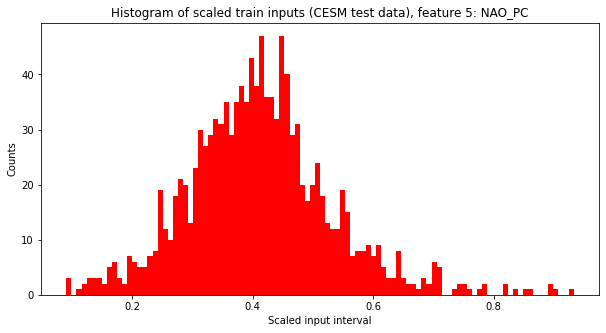

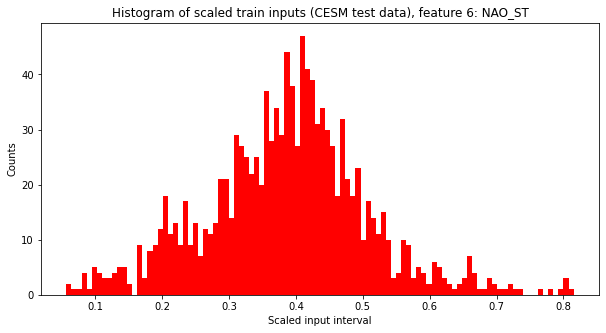

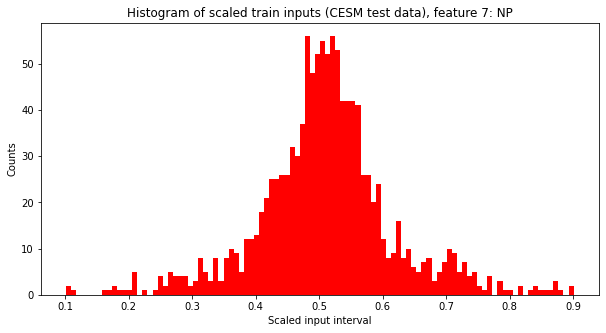

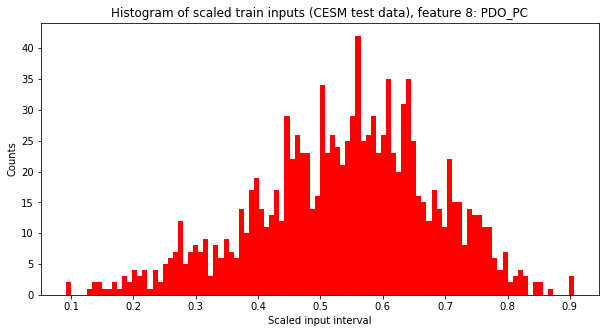

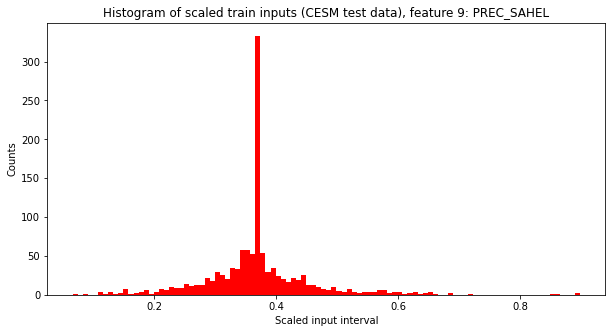

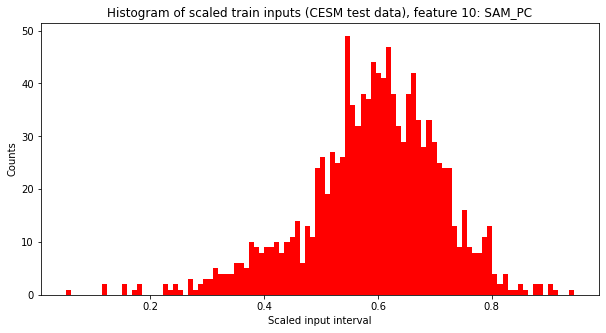

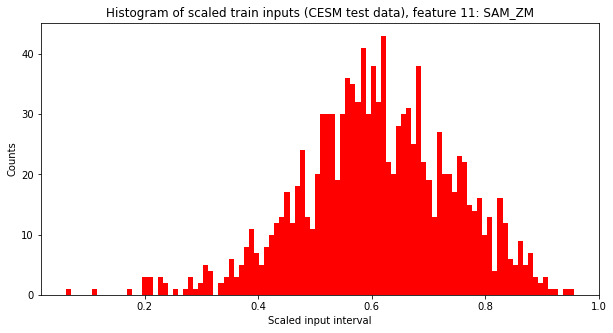

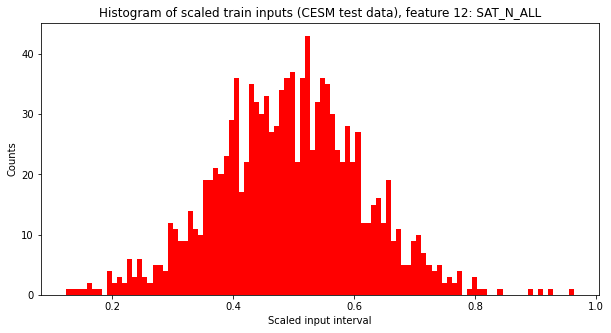

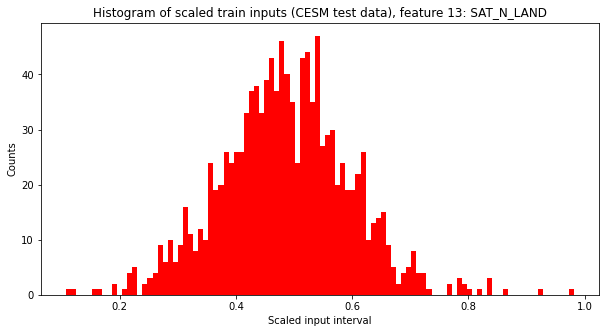

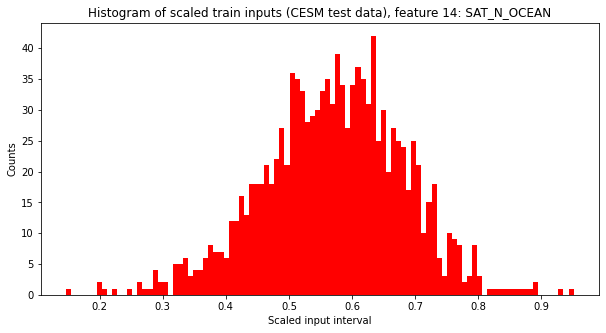

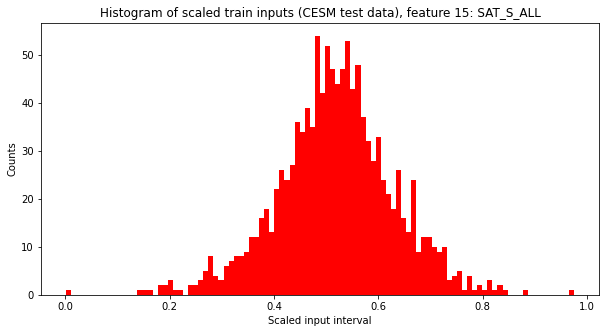

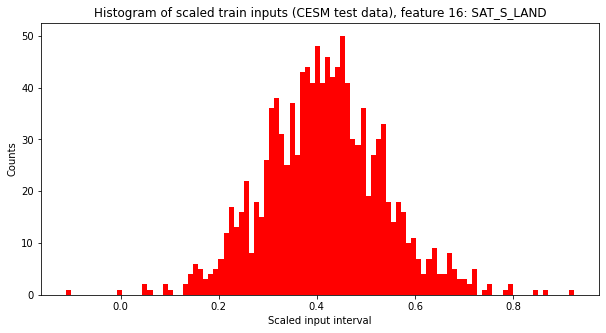

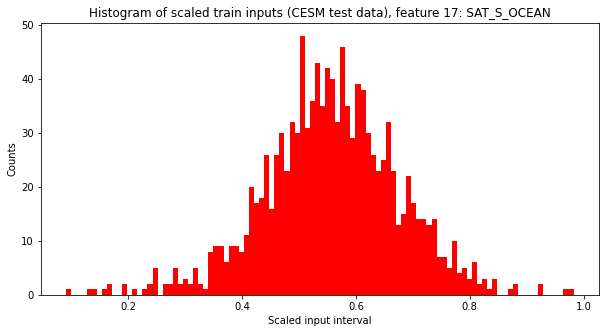

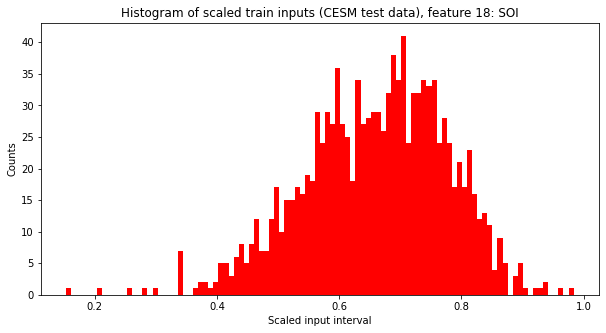

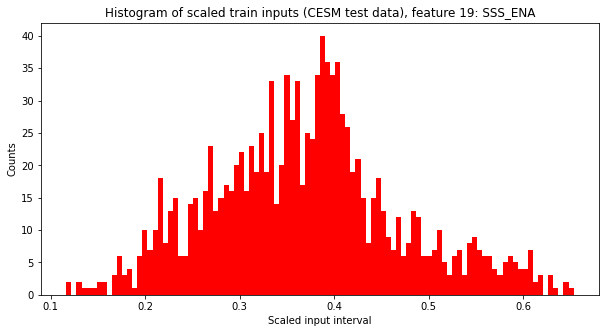

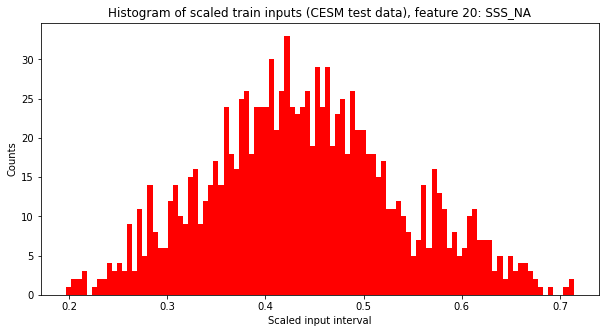

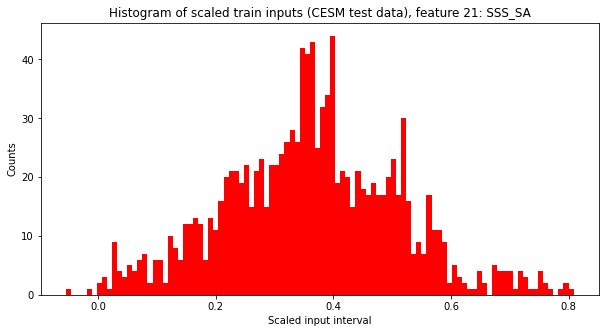

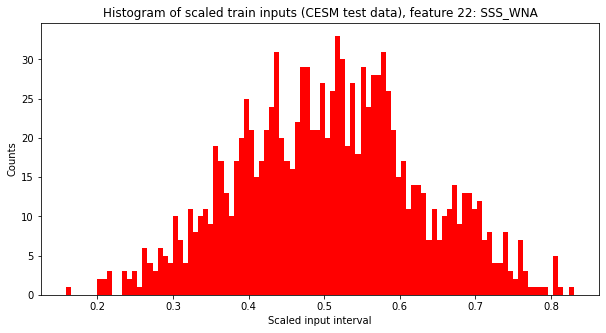

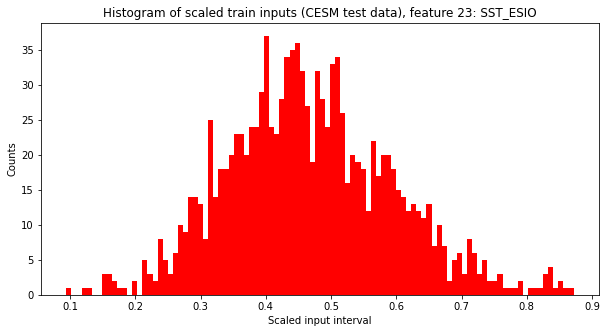

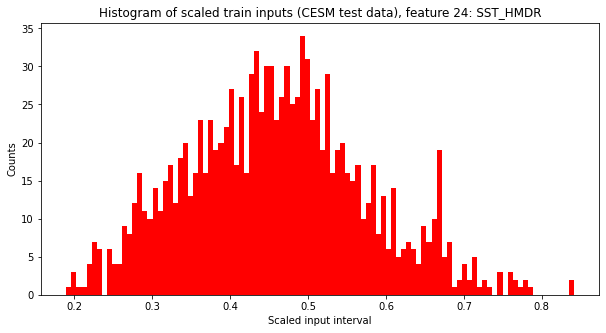

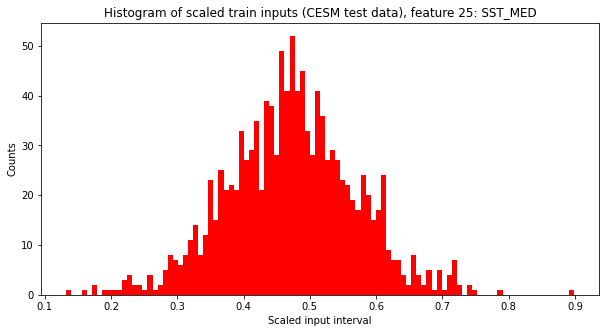

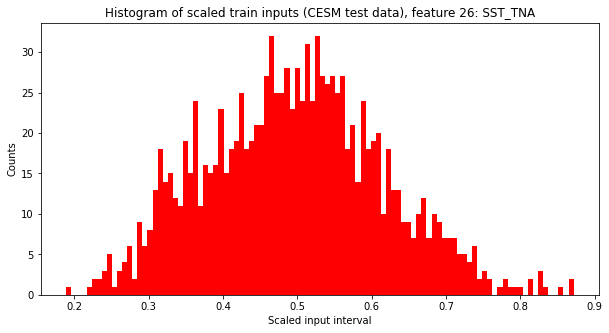

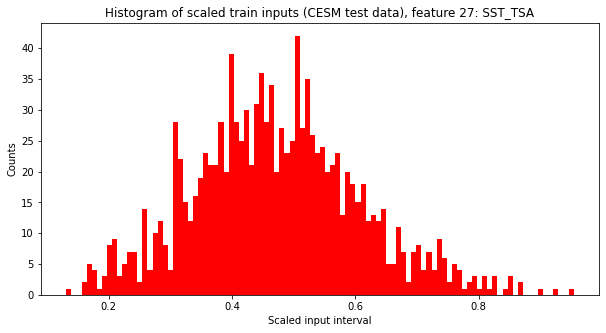

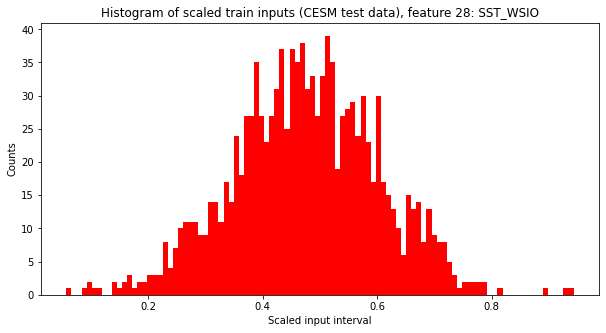

In [15]:
## Plot histogram of scaled inputs.

# FOCI: Loop over input features:
for i in range(len(input_features)):
    
    # Plot:
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(test_input_scaled_FOCI[:,0,i], nBins, color="blue")
    axes.set_xlabel("Scaled input interval")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of scaled train inputs (FOCI test data), feature "+str(i)+": "+input_features[i])
    plt.show()

# CESM: Loop over input features:
for i in range(len(input_features)):
    
    # Plot:
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(test_input_scaled_CESM[:,0,i], nBins, color="red")
    axes.set_xlabel("Scaled input interval")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of scaled train inputs (CESM test data), feature "+str(i)+": "+input_features[i])
    plt.show()



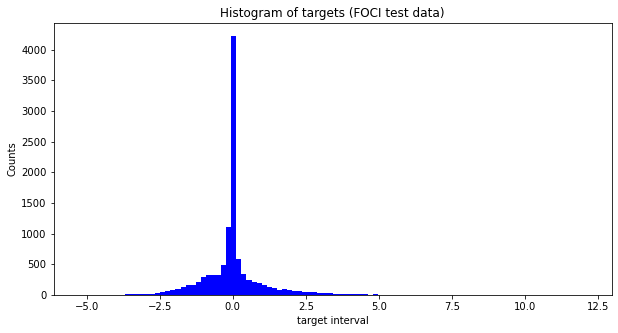

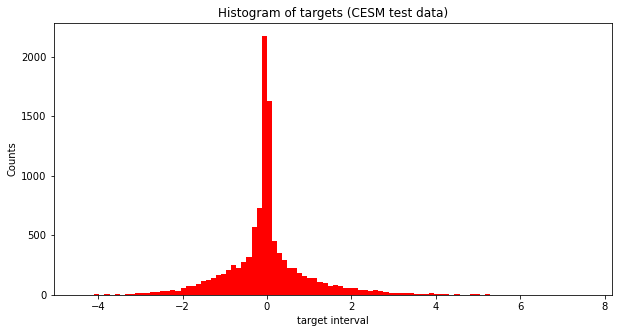

In [17]:
## Plot histogram of targets (lead 0).

# FOCI:
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target_FOCI.values[:,0], nBins, color="blue")
axes.set_xlabel("target interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of targets (FOCI test data)")
plt.show()

# CESM:
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target_CESM.values[:,0], nBins, color="red")
axes.set_xlabel("target interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of targets (CESM test data)")
plt.show()

In [42]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(
    weight_init=weight_init,
    bias_init=bias_init, 
    CNN_filters=CNN_filters,
    CNN_kernel_sizes=CNN_kernel_sizes, 
    fc_units=fc_units, 
    fc_hidden_act=fc_hidden_act,
    output_act=output_act,
    input_length=input_length,
    n_channels=len(input_features), 
    batch_size=batch_size,
    learning_rate=learning_rate, 
    loss_function=loss_function
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 20, 10)            1460      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 10)            40        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 10)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 20)            1020      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 20)            80        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 20)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)              

In [10]:
## Select ESM and target horizon:

# Select ESM:
ESM_string = 'CESM'

# Select target:
target_string = 'PREC_SAHEL_lead1'

In [11]:
# Set inputs and targets according to selection:
if ESM_string == 'FOCI':
    
    train_input_scaled = train_input_scaled_FOCI
    test_input_scaled = test_input_scaled_FOCI
    train_target = train_target_FOCI
    test_target = test_target_FOCI

else:
    
    train_input_scaled = train_input_scaled_CESM
    test_input_scaled = test_input_scaled_CESM
    train_target = train_target_CESM
    test_target = test_target_CESM
    
# Extract targets for desired target horizon:
train_target = train_target[target_string].values
test_target = test_target[target_string].values



In [45]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(test_input_scaled, test_target))

Epoch 1/100
539/539 - 1s - loss: 0.9940 - mse: 0.9940 - correlation_coefficient: 0.0967 - val_loss: 1.0754 - val_mse: 1.0754 - val_correlation_coefficient: 0.1192
Epoch 2/100
539/539 - 1s - loss: 0.9627 - mse: 0.9627 - correlation_coefficient: 0.1551 - val_loss: 1.0675 - val_mse: 1.0675 - val_correlation_coefficient: 0.1505
Epoch 3/100
539/539 - 1s - loss: 0.9558 - mse: 0.9558 - correlation_coefficient: 0.1778 - val_loss: 1.0577 - val_mse: 1.0577 - val_correlation_coefficient: 0.1763
Epoch 4/100
539/539 - 1s - loss: 0.9484 - mse: 0.9484 - correlation_coefficient: 0.1968 - val_loss: 1.0503 - val_mse: 1.0503 - val_correlation_coefficient: 0.2011
Epoch 5/100
539/539 - 1s - loss: 0.9393 - mse: 0.9393 - correlation_coefficient: 0.2116 - val_loss: 1.0417 - val_mse: 1.0417 - val_correlation_coefficient: 0.2116
Epoch 6/100
539/539 - 1s - loss: 0.9316 - mse: 0.9316 - correlation_coefficient: 0.2423 - val_loss: 1.0370 - val_mse: 1.0370 - val_correlation_coefficient: 0.2212
Epoch 7/100
539/539 - 

539/539 - 1s - loss: 0.7070 - mse: 0.7070 - correlation_coefficient: 0.4973 - val_loss: 0.9903 - val_mse: 0.9903 - val_correlation_coefficient: 0.2918
Epoch 52/100
539/539 - 1s - loss: 0.7034 - mse: 0.7034 - correlation_coefficient: 0.5162 - val_loss: 0.9750 - val_mse: 0.9750 - val_correlation_coefficient: 0.3059
Epoch 53/100
539/539 - 1s - loss: 0.7006 - mse: 0.7006 - correlation_coefficient: 0.5157 - val_loss: 0.9817 - val_mse: 0.9817 - val_correlation_coefficient: 0.3017
Epoch 54/100
539/539 - 1s - loss: 0.6953 - mse: 0.6953 - correlation_coefficient: 0.5137 - val_loss: 1.0013 - val_mse: 1.0013 - val_correlation_coefficient: 0.2842
Epoch 55/100
539/539 - 1s - loss: 0.6895 - mse: 0.6895 - correlation_coefficient: 0.5289 - val_loss: 0.9944 - val_mse: 0.9944 - val_correlation_coefficient: 0.2879
Epoch 56/100
539/539 - 1s - loss: 0.6878 - mse: 0.6878 - correlation_coefficient: 0.5330 - val_loss: 0.9933 - val_mse: 0.9933 - val_correlation_coefficient: 0.2903
Epoch 57/100
539/539 - 1s - l

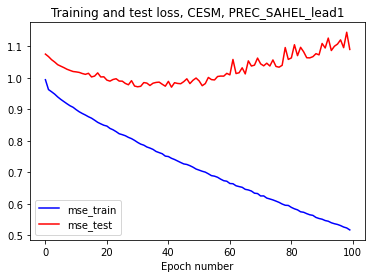

In [46]:
# Plot train and test_loss (mse):
plt.plot(history.history['loss'], color = 'blue', label = 'mse_train')
plt.plot(history.history['val_loss'], color = 'red', label = 'mse_test')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and test loss, '+ESM_string+', '+target_string)
plt.legend()
plt.show() 

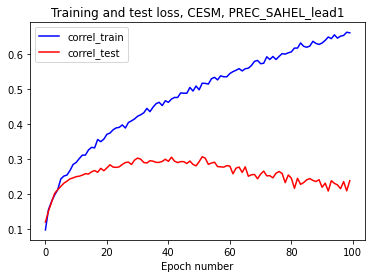

In [47]:
# Plot correlation of prediction and targets on train and test data:
plt.plot(history.history['correlation_coefficient'], color = 'blue', label = 'correl_train')
plt.plot(history.history['val_correlation_coefficient'], color = 'red', label = 'correl_test')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and test loss, '+ESM_string+', '+target_string)
plt.legend()
plt.show() 

### Discussion on first attempt to train multivariate CNN/fc model:

- Tried to predict PREC_SAHEL with lead time 1 month for CESM.
- Used **all** indices as input features with historic data from the last 24 months.

The model overfits after 30 epochs. Need early stopping for the training process.
Different model runs lead to slightly different results, due to random initialization of weights and biases and since we use *stochastic* gradient descent learning.

Show results (mse, correlation) as average over multiple runs, to avoid having a *lucky shot* result, that is not reproducible.

In [14]:
## Multirun with early stopping to predict PREC_SAHEL with lead time 1 month for CESM data from all inputs:

# Specify number of runs:
n_runs = 3

# Specify number of epochs for early stopping:
n_epochs = 30

# Initialize storage for mse and correlation on training and test data for all runs:
mse_train_all = np.zeros(n_runs)
mse_test_all = np.zeros(n_runs)
correl_train_all = np.zeros(n_runs)
correl_test_all = np.zeros(n_runs)

# Loop over desired number of runs:
for n in range(n_runs):
    
    # Print status:
    print('run',n+1,'from',n_runs)

    # Set up compiled CNN/fc model:
    model = set_CNN_fc(
        weight_init=weight_init,
        bias_init=bias_init, 
        CNN_filters=CNN_filters,
        CNN_kernel_sizes=CNN_kernel_sizes, 
        fc_units=fc_units, 
        fc_hidden_act=fc_hidden_act,
        output_act=output_act,
        input_length=input_length,
        n_channels=len(input_features), 
        batch_size=batch_size,
        learning_rate=learning_rate, 
        loss_function=loss_function
    )
    
    # Train model on scaled inputs and un-scaled targets:
    history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                        shuffle=True, verbose=0, validation_data=(test_input_scaled, test_target))
    
    # Get model predictions on training and test data:
    train_pred = model.predict(train_input_scaled)
    test_pred = model.predict(test_input_scaled)
    
    # Manually compute mse and correlation between model predictions and true targets on training and test data:
    mse_train = np.round(np.mean((train_target-train_pred[:,0])**2),3)
    mse_test = np.round(np.mean((test_target-test_pred[:,0])**2),3)
    correl_train = np.round(np.corrcoef(np.stack([train_target,train_pred[:,0]]))[0,1],3)
    correl_test = np.round(np.corrcoef(np.stack([test_target,test_pred[:,0]]))[0,1],3)
    
    # Store mse and correlation for current run:
    mse_train_all[n] = mse_train
    mse_test_all[n] = mse_test
    correl_train_all[n] = correl_train
    correl_test_all[n] = correl_test

# Output average mse and correlation:
print('\n',ESM_string,target_string,', averaged over',n_runs,'runs\n')
print('avg. mse_train:',np.round(np.mean(mse_train_all),3))
print('avg. mse_test:',np.round(np.mean(mse_test_all),3))
print('avg. correl_train:',np.round(np.mean(correl_train_all),3))
print('avg. correl_test:',np.round(np.mean(correl_test_all),3))

run 1 from 3
run 2 from 3
run 3 from 3

 CESM PREC_SAHEL_lead1 , averaged over 3 runs

avg. mse_train: 0.801
avg. mse_test: 0.995
avg. correl_train: 0.448
avg. correl_test: 0.317


In [ ]:
#### Store parameters file and trained model, need lookback functionality!
#### Take care of (hyper-)parameter optimization in multirun experiments.
#### Try for both ESMs and all target horizons.
#### Visualize model predictions vs. true targets.